In [19]:
! pip install opencv-python tensorflow matplotlib

In [20]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import tensorflow as tf
from tensorflow import keras 
from keras.models import Model
from keras.layers import Layer , Dense , Conv2D , MaxPooling2D , Flatten , Input

In [22]:
pos_path = os.path.join('Data','positive')
neg_path = os.path.join('Data' , 'negative')
anc_path = os.path.join('Data' , 'anchor')

In [23]:
# os.makedirs(pos_path)
# os.makedirs(neg_path)
# os.makedirs(anc_path)

In [24]:
# using labelled faces in the wild dataset  :-  https://vis-www.cs.umass.edu/lfw/

In [25]:
# umcompress Tar GZ labelled faces in the wild dataset
# !tar -xf lfw.tar

In [26]:
# moving lfw images to the negative 

# for direc in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw' , direc)):
#         existing_path = os.path.join('lfw' , direc , file)
#         new_path = os.path.join('Data' , 'negative' , file)
#         os.replace(existing_path , new_path)
   

In [27]:
# collecting positive and anchor images

In [28]:
# importing uuid ( universally unique identifiers )
import uuid

In [29]:
# cap = cv2.VideoCapture(0)

# while  cap.isOpened():
 
#     ret , frame = cap.read() 

#     # First get the frame dimensions
#     height, width = frame.shape[:2]
        
#     # Calculate the starting coordinates to center the 250x250 crop
#     start_y = (height - 250) // 2
#     start_x = (width - 250) // 2
        
#     # Crop the frame
#     frame = frame[start_y:start_y+250, start_x:start_x+250, :]

#     # collecting anchor images 
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('a'):
#       imgname = os.path.join(anc_path, f'{uuid.uuid1()}.jpg')
#       cv2.imwrite(imgname, frame)
        
    
#     # collecting positive images 
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('p'):
#       imgname = os.path.join(pos_path, f'{uuid.uuid1()}.jpg')
#       cv2.imwrite(imgname, frame)

    
#     cv2.imshow('frame' , frame ) 
    
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('q'):
#         break 

# cap.release()
# # cv2.destroyAllWindows()

In [30]:
# building tensorflow pipeline
anchor = tf.data.Dataset.list_files('Data/anchor/*.jpg').take(300)
positive = tf.data.Dataset.list_files('Data/positive/*.jpg').take(300)
negative = tf.data.Dataset.list_files('Data/negative/*.jpg').take(300)

In [31]:
anchor.as_numpy_iterator().next()

b'Data/anchor/7a69e870-b918-11ef-bf97-cedcff991510.jpg'

In [32]:
# preprocessing 
def preprocess(file_path):
    byte_image = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_image)
    img = tf.image.resize(img , (100 , 100))
    img = img /255.0
    return img 

In [33]:
# tf.data.Dataset.zip() combines multiple datasets into a single dataset of tuples.

positives = tf.data.Dataset.zip((
    anchor, 
    positive, 
    tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
))

negatives = tf.data.Dataset.zip((
    anchor, 
    negative, 
    tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
))

data = positives.concatenate(negatives)

In [34]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [35]:
samples = data.as_numpy_iterator()

In [36]:
example = samples.next()   #  (anchor image , positive image/negative  , label(0/1) )
print(example)

(b'Data/anchor/cd7d7e00-b918-11ef-bf97-cedcff991510.jpg', b'Data/positive/3c32166c-b919-11ef-bf97-cedcff991510.jpg', 1.0)


In [37]:
def preprocess_both(input_image , validation_image , label ):
    return( preprocess(input_image) , preprocess(validation_image) , label )

In [38]:
res = preprocess_both(*example)

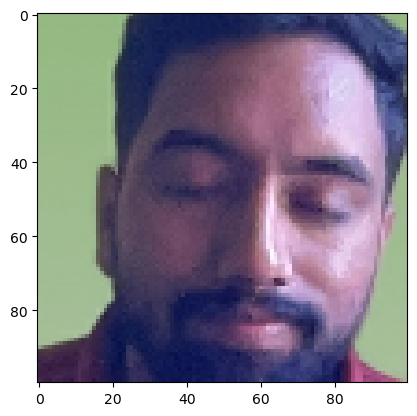

In [39]:
plt.imshow(res[1]) 

In [40]:
data = data.map(preprocess_both)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [41]:
train_data = data.take(round(len(data)* 0.7))  # around 70% of the data 
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)   # Keep 8 batches ready in memory

In [42]:
test_data = data.skip(round(len(data)* 0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [43]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(pool_size= (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(pool_size= (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(pool_size= (2,2) , padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# build Distace Layer (creating custom layer )

In [47]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
       
    def call(self, input_embedding, validation_embedding):
        # Ensure input tensors are properly converted
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)


In [48]:
l1 = L1Dist()

In [49]:
def make_final_model(): 
    # Create the embedding model
    embedding_model = make_embedding()
    
    # Anchor image input in the network
    input_image = Input(name='input_image', shape=(100,100,3))
    
    # Validation image input in the network 
    validation_image = Input(name='validation_image', shape=(100,100,3))
    
    # Generate embeddings
    input_embedding = embedding_model(input_image)
    validation_embedding = embedding_model(validation_image)
    
    # Combine Siamese distance components
    dist_layer = L1Dist()
    dist_layer._name = 'distance'
    distances = dist_layer(input_embedding, validation_embedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='final_Model')



In [87]:
model = make_final_model()

In [88]:
model.summary()

Model: "final_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
Binary_Cross_loass = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [53]:
# Establish checkpoints

In [54]:
checkpoint_dir = './Training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir , 'ckpt')
checkpoint = tf.train.Checkpoint( opt = opt , model = model)

In [66]:
# building Train Step Function

In [55]:
@tf.function       # @tf.function: Decorator to compile function for faster execution
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # 1. Get batch data
        X = batch[:2]  # Input images
        y = batch[2]   # Labels
        
        # 2. Forward pass
        yhat = model(X , training = True)  # Get predictions

         # Fix shape mismatch - squeeze extra dimensions
        yhat = tf.squeeze(yhat)  # Remove extra dimensions
        y = tf.cast(y, tf.float32)  # Ensure same dtype
        
        # 3. Calculate loss
        loss = Binary_Cross_loass(y, yhat)
        
    print(loss)
    
    # 4. Calculate gradients
    grad = tape.gradient(loss, model.trainable_variables)
    
    # 5. Update weights
    opt.apply_gradients(zip(grad, model.trainable_variables))
    
    # 6. Return loss value
    return loss
    

In [56]:
#build training loop 

In [57]:
def train(data , Epochs):
    for epoch in range(1 , Epochs + 1):
        print('\n Epoch {}/{}'.format(epoch , Epochs))
        progbar = tf.keras.utils.Progbar(len(train_data))

        #loop through each batch
        for idx , batch in enumerate(train_data):
            train_step(batch)
            progbar.update(idx+1)

        #save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            

In [58]:
train(train_data , 50)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

 Epoch 2/50


2025-01-19 01:21:46.408383: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 3/50


2025-01-19 01:22:26.769113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 5/50


2025-01-19 01:23:44.730084: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 9/50


2025-01-19 01:26:18.596273: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

 Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 16/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 17/50


2025-01-19 01:31:27.641787: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 18/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 19/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 20/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 21/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 22/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 23/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 24/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 25/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 26/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 27/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 28/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 29/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 30/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 31/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 32/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 33/50


2025-01-19 01:41:40.150768: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 34/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 35/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 36/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 37/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 38/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 39/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 40/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 41/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step

 Epoch 42/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 43/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

 Epoch 44/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 45/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 46/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 47/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 48/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 49/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 50/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


In [59]:
# Evaluate Model 

In [60]:
from tensorflow.keras.metrics import Precision , Recall

In [61]:
#get batch of test data
test_input , test_val , y_true = test_data.as_numpy_iterator().next()

In [86]:
# make predictions
y_hat = model.predict([test_input , test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


array([[[1.1428651e-04],
        [9.9999875e-01],
        [3.6707826e-09],
        [1.0000000e+00],
        [2.5731178e-11],
        [9.9999994e-01],
        [1.0000000e+00],
        [7.3243456e-10],
        [9.9982506e-01],
        [9.9999923e-01],
        [9.9996120e-01],
        [9.9998814e-01],
        [9.9999946e-01],
        [9.9999970e-01],
        [9.9958634e-01],
        [6.9668972e-11]]], dtype=float32)

In [89]:
y_pred = [1 if float(prediction) > 0.5 else 0 for prediction in y_hat.flatten()]

In [90]:
y_pred

[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]

In [91]:
y_true

array([0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [92]:
r = Recall()
r.update_state(y_true , y_hat)
r.result().numpy()

1.0

In [93]:
p = Precision()
p.update_state(y_true , y_hat)
p.result().numpy()

1.0

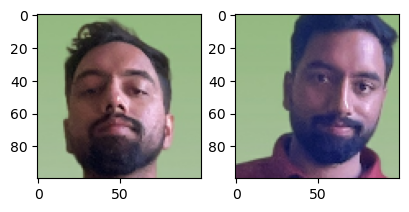

In [68]:
# Visualizing results 
plt.figure(figsize = (20 , 20))
plt.subplot(8 , 8 ,1)
plt.imshow(test_input[1])
plt.subplot(8 , 8 ,2)
plt.imshow(test_val[1])


In [99]:
# Model Evaluation 
def model_evaluate(test_data):
    y_actual = []
    y_predicted = []
    
    # Iterate through test data
    for test_input, test_val, y_true in test_data.as_numpy_iterator():
        # Collect actual values
        y_actual.extend(y_true)  
        
        # Make predictions
        y_hat = model.predict([test_input, test_val])
        y_pred = [1 if float(prediction) > 0.5 else 0 for prediction in y_hat.flatten()]
        y_predicted.extend(y_pred)  
    
    # Convert lists to numpy arrays for metrics
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    
    # Calculate metrics
    r = Recall()
    r.update_state(y_actual, y_predicted)
    print(f'Recall: {r.result().numpy():.4f}')
    
    p = Precision()
    p.update_state(y_actual, y_predicted)
    print(f'Precision: {p.result().numpy():.4f}')

    return r.result().numpy(), p.result().numpy()

In [100]:
model_evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Recall: 1.0000
Precision: 1.0000


(1.0, 1.0)

In [119]:
# save Model 

In [71]:
model.save('Facial_Recognition_Model.h5')

In [115]:
model.save('Facial_Recognition_Model.keras')

In [98]:
model = tf.keras.models.load_model('Facial_Recognition_Model.h5' ,
                                  custom_objects = {'L1Dist' : L1Dist , 'BinaryCrossentropy' : tf.losses.BinaryCrossentropy})

In [101]:
model.predict([test_input , test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


array([[[1.1428651e-04],
        [9.9999875e-01],
        [3.6707826e-09],
        [1.0000000e+00],
        [2.5731178e-11],
        [9.9999994e-01],
        [1.0000000e+00],
        [7.3243456e-10],
        [9.9982506e-01],
        [9.9999923e-01],
        [9.9996120e-01],
        [9.9998814e-01],
        [9.9999946e-01],
        [9.9999970e-01],
        [9.9958634e-01],
        [6.9668972e-11]]], dtype=float32)

In [102]:
# Real Time Test 

In [103]:
# verification Function

# Detection Threshold :- Metric above which a prediction is considered positive 
# verification Threshold :- proportion of positive predictions / total positive samples 
 

def verify(model, detection_threshold, verification_threshold):
    results = []
    
    # Get list of verification images, excluding hidden files and directories
    verification_images = [f for f in os.listdir(os.path.join('Application_Data', 'Verification_images')) 
                         if not f.startswith('.') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Process all verification images
    for image in verification_images:
        validation_img = preprocess(os.path.join('Application_Data', 'Verification_images', image))
        input_img = preprocess(os.path.join('Application_Data', 'Input_image', 'Input_image.jpg'))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Calculate verification after processing all images
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(verification_images)  # Using filtered list length
    verified = verification > verification_threshold
    
    return results, verified

In [104]:
verify(model , 0.5 , 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

([array([[[0.9974093]]], dtype=float32),
  array([[[0.9998994]]], dtype=float32),
  array([[[0.99999976]]], dtype=float32),
  array([[[0.9994564]]], dtype=float32),
  array([[[0.99999887]]], dtype=float32),
  array([[[0.91436875]]], dtype=float32),
  array([[[0.99999726]]], dtype=float32),
  array([[[0.9999999]]], dtype=float32),
  array([[[0.9681955]]], dtype=float32),
  array([[[0.9999663]]], dtype=float32),
  array([[[0.99999994]]], dtype=float32),
  array([[[0.9999896]]], dtype=float32),
  array([[[0.994415]]], dtype=float32),
  array([[[0.999585]]], dtype=float32),
  array([[[0.9999998]]], dtype=float32),
  array([[[0.9997127]]], dtype=float32),
  array([[[0.9999965]]], dtype=float32),
  array([[[0.99996895]]], dtype=float32),
  array([[[0.74006003]]], dtype=float32),
  array([[[0.99999875]]], dtype=float32),
  array([[[0.9999993]]], dtype=float32),
  array([[[0.9999019]]], dtype=float32),
  array([[[0.9999997]]], dtype=float32),
  array([[[0.9999824]]], dtype=float32),
  array([[

In [77]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    height, width = frame.shape[:2]
            
    
    start_y = (height - 250) // 2
    start_x = (width - 250) // 2
            
    frame = frame[start_y:start_y+250, start_x:start_x+250, :]
    
    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('Application_Data' , 'Input_image' , 'Input_image.jpg' ) , frame)

        results, verified =  verify( model  , 0.5 , 0.5)

        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━